## Usefule Links:
- Virtual environment and keras: https://www.tutorialspoint.com/keras/keras_installation.htm


In [ ]:
#Read all data [194 users' oversampled data]
import csv
import pandas as pd
dataset=pd.read_csv('dataset/AllOversampledNData.csv')
dataset.head()

In [16]:
#replace the user ID by class name and count the number of sample in each class
dataset['ID'] = pd.factorize(dataset['ID'])[0]
dataset.groupby(['ID'])['ID'].count()

ID
0      1000
1      1000
2      1000
3      1000
4      1000
       ... 
188    1000
189    1000
190    1000
191    1000
192    1000
Name: ID, Length: 193, dtype: int64

In [22]:
#seperate the profile in two groups: (i) Training profile (0-95), and (ii) auxiliary profile (96-193)
totalUser= len(pd.unique(dataset['ID']))
trainingData = dataset[dataset['ID'] < int(totalUser/2)]
auxilaryData = dataset[dataset['ID'] >= int(totalUser/2)]
print("Total user in training dataset:", len(pd.unique(trainingData['ID'])))
print("Total user in auxiliary dataset:", len(pd.unique(auxilaryData['ID'])))

Total user in training dataset: 96
Total user in auxiliary dataset: 97


In [34]:
#Prepare the traning data for training and testing the model
import tensorflow
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X=trainingData.drop(columns=['ID'])
y=trainingData['ID']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=22)
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.2, random_state=22)

ytrain = to_categorical(ytrain)
yval = to_categorical(yval)
ytest = to_categorical(ytest)

In [35]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xval.shape)
print(yval.shape)
print(Xtest.shape)
print(ytest.shape)

(62719, 65)
(62719, 96)
(15680, 65)
(15680, 96)
(19600, 65)
(19600, 96)


In [38]:
# import all necessary package for a neural network
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inlineimport keras
from keras.layers import Dense, Dropout, Input,Activation,Dropout, Flatten
from keras.models import Model,Sequential
from keras.datasets import mnist
#from tqdm import tqdm
#from keras.layers.advanced_activations import LeakyReLU
from keras.layers import BatchNormalization
from keras.optimizers import Adam
#import torch.nn.functional as F

In [40]:
#define optimizers for neural network
from keras.optimizers import SGD, RMSprop, Adam
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

def RMSprop_optimizer():
    return RMSprop(lr=0.001, rho=0.9)

In [43]:
#neural network architecture for model training

def create_classifier(release=False,totalClass=10):
  classifier = Sequential()
  classifier.add(Dense(128, input_dim=65))
  classifier.add(BatchNormalization())
  classifier.add(Activation('relu'))

  #classifier.add(Dense(256))
  #classifier.add(BatchNormalization())
  #classifier.add(Activation('relu'))

  classifier.add(Dense(256))
  classifier.add(BatchNormalization())
  classifier.add(Activation('relu'))

  classifier.add(Dense(256))
  classifier.add(BatchNormalization())
  classifier.add(Activation('relu'))

  #classifier.add(Dense(256))
  #classifier.add(BatchNormalization())
  #classifier.add(Activation('relu'))

  classifier.add(Dense(128))
  classifier.add(BatchNormalization())
  classifier.add(Activation('relu'))

  #if release:
  classifier.add(Dense(totalClass, activation='softmax'))
  #else:
  #   classifier.add(Dense(Tuser))
  #np.log_softmax_v2(a, axis=axis)
  #classifier.add(F.softmax(a, dim=1))

  classifier.compile(loss='categorical_crossentropy', optimizer=RMSprop_optimizer(),metrics=['accuracy'])
  return classifier

Clasf=create_classifier()
Clasf.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 128)               8448      
                                                                 
 batch_normalization_12 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 256)               33024     
                                                                 
 batch_normalization_13 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 activation_13 (Activation)  (None, 256)              

c:\Users\mdmor\PythonProjects\ModelInversion\.venv\Lib\site-packages\keras\optimizers\legacy\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [44]:
#Train the classifier seperately for black-box attack
import keras

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=5, verbose=1, factor=0.5,min_lr=0.0001)
callbacks_list = [learning_rate_reduction]

Classfier2= create_classifier(True,96)

#------Comment will start from here
lossc='categorical_crossentropy'
optimizerc=RMSprop(lr=0.001, rho=0.9)
Classfier2.compile(loss=lossc, optimizer=optimizerc,metrics=['accuracy'])
#------Comments will end from here
historyc2 =  Classfier2.fit(Xtrain, ytrain, batch_size=64, epochs=50, validation_data=(Xval, yval),verbose=1, callbacks=callbacks_list)

Epoch 1/50
980/980 [==============================] - 5s 4ms/step - loss: 1.5347 - accuracy: 0.4619 - val_loss: 1.1211 - val_accuracy: 0.5664 - lr: 0.0010
Epoch 2/50
980/980 [==============================] - 4s 4ms/step - loss: 0.9263 - accuracy: 0.6373 - val_loss: 0.8340 - val_accuracy: 0.6774 - lr: 0.0010
Epoch 3/50
980/980 [==============================] - 5s 5ms/step - loss: 0.6656 - accuracy: 0.7444 - val_loss: 0.7002 - val_accuracy: 0.7320 - lr: 0.0010
Epoch 4/50
980/980 [==============================] - 8s 8ms/step - loss: 0.5009 - accuracy: 0.8117 - val_loss: 0.5448 - val_accuracy: 0.7936 - lr: 0.0010
Epoch 5/50
980/980 [==============================] - 10s 10ms/step - loss: 0.3875 - accuracy: 0.8573 - val_loss: 0.3879 - val_accuracy: 0.8544 - lr: 0.0010
Epoch 6/50
980/980 [==============================] - 8s 8ms/step - loss: 0.3171 - accuracy: 0.8842 - val_loss: 0.3865 - val_accuracy: 0.8652 - lr: 0.0010
Epoch 7/50
980/980 [==============================] - 8s 8ms/step - 

Text(0.5, 0, 'epochs')

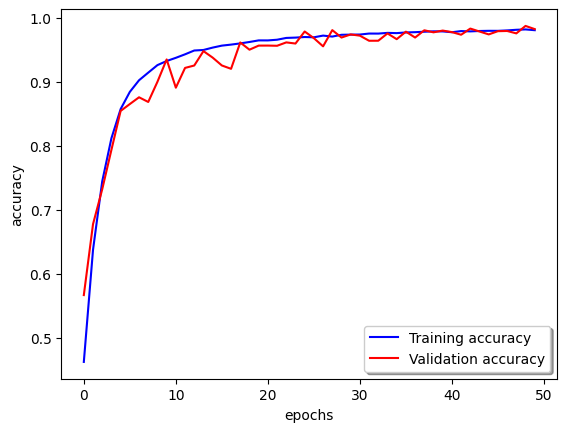

In [45]:
# Plot the classifier loss and accuracy curves for training and validation data
import matplotlib.pyplot as plt
plt.plot(historyc2.history['accuracy'], color='b', label="Training accuracy")
plt.plot(historyc2.history['val_accuracy'], color='r',label="Validation accuracy")
legend = plt.legend(loc='best', shadow=True)
plt.ylabel('accuracy')
plt.xlabel('epochs')

In [46]:
#Performance of the classifier
Classfier2.compile(loss='categorical_crossentropy', optimizer=Adam(),metrics=['accuracy'])
loss, accuracy = Classfier2.evaluate(Xtest, ytest)
#print('Test score:', score)
print('Loss:', loss)
print('Accuracy:', accuracy)

613/613 [==============================] - 1s 1ms/step - loss: 0.0652 - accuracy: 0.9801
Loss: 0.06518296152353287
Accuracy: 0.9800510406494141
